In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC as SVMClassifier
from tools.preprocess import load_datasets, preprocess_hepatitis_datasets
from tools.distance import ManhattanDistance, EuclideanDistance
from tools.voting import MajorityClassVote, InverseDistanceWeightedVote, ShepardsWorkVote
from tools.knn import KNNClassifier, cross_validate_knn
from tools.svm import cross_validate_svm
import itertools
from functools import partial
import logging

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.train.arff")
test_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,50.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',b'no',b'no',b'no',0.9,135.0,42.0,3.5,NaN,b'no',b'LIVE'
1,45.0,b'male',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'yes',b'no',b'no',b'no',1.0,85.0,75.0,NaN,NaN,b'no',b'LIVE'
2,54.0,b'female',b'no',b'no',b'yes',b'yes',b'no',b'?',b'?',b'yes',b'no',b'yes',b'no',3.9,120.0,28.0,3.5,43.0,b'yes',b'DIE'
3,35.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'?',b'?',b'yes',b'yes',b'yes',b'no',1.5,138.0,58.0,2.6,NaN,b'yes',b'DIE'
4,24.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',1.0,NaN,34.0,4.1,NaN,b'yes',b'LIVE'


In [3]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                  0
SEX                  0
STEROID              0
ANTIVIRALS           0
FATIGUE              0
MALAISE              0
ANOREXIA             0
LIVER_BIG            0
LIVER_FIRM           0
SPLEEN_PALPABLE      0
SPIDERS              0
ASCITES              0
VARICES              0
BILIRUBIN           60
ALK_PHOSPHATE      290
SGOT                40
ALBUMIN            160
PROTIME            670
HISTOLOGY            0
Class                0
dtype: int64

In [4]:
for df in train_dfs + test_dfs:
    preprocess_hepatitis_datasets(df)

train_dfs[0].head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,29,0,1,0,2,1,1,1,1,1,1,1,1,-0.451756,0.633293,-0.478208,-0.529857,0.000000,0,0
1,24,1,1,0,2,2,1,2,1,2,1,1,1,-0.359462,-0.431303,-0.097232,0.000000,0.000000,0,0
2,33,0,1,0,2,2,1,0,0,2,1,2,1,2.317073,0.313914,-0.639834,-0.529857,-1.016174,1,1
3,14,0,1,0,2,1,1,0,0,2,2,2,1,0.102010,0.697169,-0.293493,-1.979173,0.000000,1,1
4,4,0,1,0,2,1,1,2,1,1,1,1,1,-0.359462,0.000000,-0.570566,0.436353,0.000000,1,0


In [5]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                0
SEX                0
STEROID            0
ANTIVIRALS         0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
BILIRUBIN          0
ALK_PHOSPHATE      0
SGOT               0
ALBUMIN            0
PROTIME            0
HISTOLOGY          0
Class              0
dtype: int64

In [6]:
k_values = [1, 3, 5, 7]
distance_funcs = [ManhattanDistance(), EuclideanDistance()]
voting_funcs = [MajorityClassVote(), InverseDistanceWeightedVote(), ShepardsWorkVote()]

results = pd.DataFrame(
    columns=[
        "k",
        "distance_func",
        "voting_func",
        "f1_mean",
        "f1_std",
    ]
)
for k, distance_func, voting_func in itertools.product(
    k_values, distance_funcs, voting_funcs
):
    knn = KNNClassifier(
        k=k,
        distance_func=distance_func,
        voting_func=voting_func,
        weights=np.ones(len(train_dfs[0].columns) - 1),
    )
    scores = cross_validate_knn(
        knn,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        k,
        distance_func.__class__.__name__,
        voting_func.__class__.__name__,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,k,distance_func,voting_func,f1_mean,f1_std
13,5,ManhattanDistance,InverseDistanceWeightedVote,0.832088,0.107074
19,7,ManhattanDistance,InverseDistanceWeightedVote,0.828617,0.106948
16,5,EuclideanDistance,InverseDistanceWeightedVote,0.817404,0.063850
17,5,EuclideanDistance,ShepardsWorkVote,0.804669,0.070711
23,7,EuclideanDistance,ShepardsWorkVote,0.802931,0.078898
22,7,EuclideanDistance,InverseDistanceWeightedVote,0.802931,0.078898
20,7,ManhattanDistance,ShepardsWorkVote,0.799728,0.095115
14,5,ManhattanDistance,ShepardsWorkVote,0.796830,0.084454
7,3,ManhattanDistance,InverseDistanceWeightedVote,0.778886,0.062668
10,3,EuclideanDistance,InverseDistanceWeightedVote,0.778606,0.064173


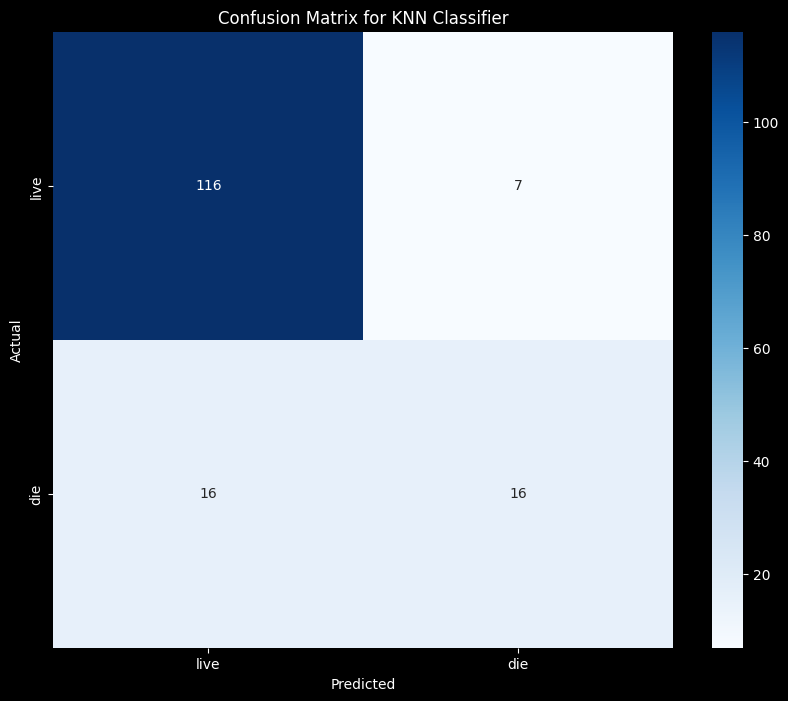

In [7]:
knn = KNNClassifier(
    k=7,
    distance_func=ManhattanDistance(),
    voting_func=InverseDistanceWeightedVote(),
    weights=np.ones(len(train_dfs[0].columns) - 1),
)
scores = cross_validate_knn(
        knn,
        train_dfs,
        test_dfs,
    target_col="Class",
    score_func=partial(confusion_matrix),
)
sum_scores = scores.sum(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sum_scores, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.yticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.show()


In [8]:
c_values = [1, 3, 5, 7]
kernal_types = ["linear", "poly", "rbf", "sigmoid"]

results = pd.DataFrame(
    columns=[
        "c",
        "kernel_type",
        "f1_mean",
        "f1_std",
    ]
)
for c, kernel_type in itertools.product(
    c_values, kernal_types
):
    svm = SVMClassifier(
        C=c,
        kernel=kernel_type,
    )
    scores = cross_validate_svm(
        svm,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        c,
        kernel_type,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,c,kernel_type,f1_mean,f1_std
8,5,linear,0.846423,0.114869
12,7,linear,0.846423,0.114869
4,3,linear,0.839587,0.130894
0,1,linear,0.797950,0.109102
14,7,rbf,0.737036,0.081698
10,5,rbf,0.728082,0.063059
11,5,sigmoid,0.725573,0.082093
15,7,sigmoid,0.720474,0.075647
7,3,sigmoid,0.710309,0.057405
1,1,poly,0.701752,0.035240


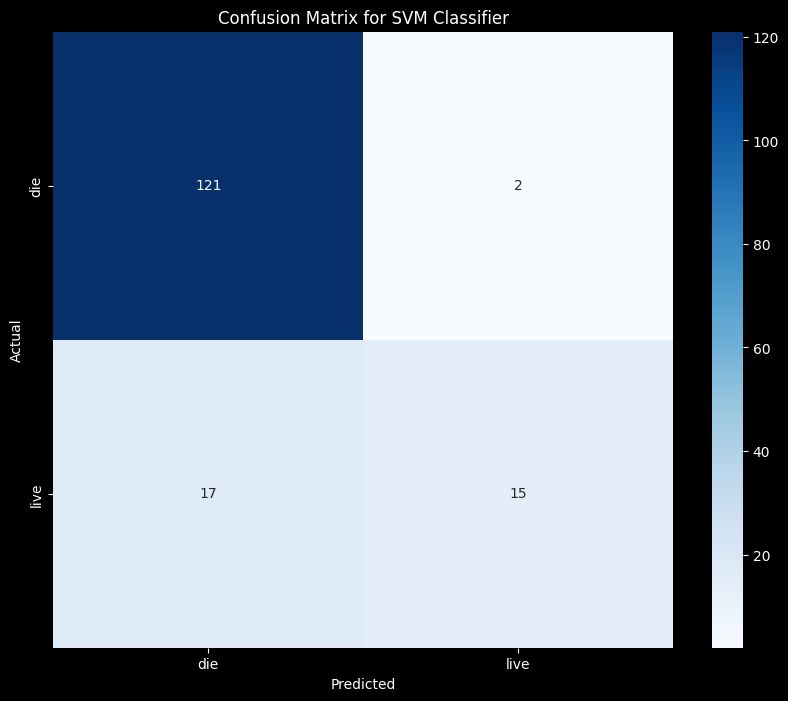

In [9]:
svm = SVMClassifier(
    C=5,
    kernel="linear",
)
scores = cross_validate_svm(
        svm,
        train_dfs,
        test_dfs,
    target_col="Class",
    score_func=partial(confusion_matrix),
)
sum_scores = scores.sum(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sum_scores, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.yticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.show()


In [10]:
sensitivity = sum_scores[0, 0] / (sum_scores[0, 0] + sum_scores[1, 0])
specificity = sum_scores[1, 1] / (sum_scores[1, 1] + sum_scores[0, 1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.8768115942028986
Specificity: 0.8823529411764706


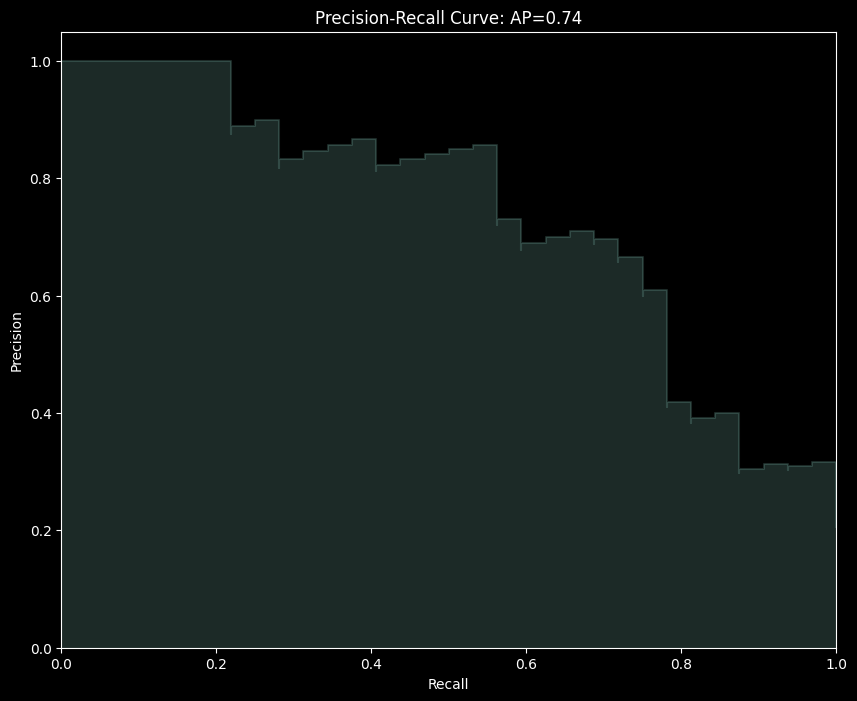

[0.03921056 0.16358854 0.04415952 0.02396025 0.12866171 0.0534298
 0.21090359 0.0627396  0.07812085 0.04976357 0.03475925 0.01976914
 0.03427112 0.17544328 0.0299734  0.02916347 0.08540985 0.09147592
 0.03332398 0.06174634 0.05613849 0.03807129 0.31870274 0.10716226
 0.00657047 0.28607318 0.01257246 0.02985685 0.10246078 0.26950358
 0.04219119 0.03245069 0.42036203 0.02299558 0.00367978 0.11034369
 0.43135356 0.04208875 0.73763209 0.14210533 0.01824438 0.08897625
 0.08659804 0.2351228  0.77254166 0.15778997 0.07328133 0.24751764
 0.02928812 0.19875721 0.0618412  0.20631045 0.1950906  0.13795795
 0.22372966 0.25338019 0.10571051 0.15816499 0.15531849 0.31043308
 0.13128054 0.08691084 0.12028311 0.21861531 0.16515328 0.13772937
 0.45071778 0.09021682 0.49491263 0.06837961 0.18140558 0.15144897
 0.30324415 0.18001924 0.07582594 0.15411162 0.11025259 0.13799739
 0.13935166 0.11653198 0.08225979 0.23755062 0.18508816 0.18481559
 0.06995136 0.1305932  0.74138128 0.06452935 0.10138861 0.51931

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Function to get predictions and true labels for all folds
def get_predictions_and_labels(classifier, train_dfs, test_dfs, target_col):
    y_true = []
    y_scores = []
    for train_df, test_df in zip(train_dfs, test_dfs):
        X_train = train_df.drop(target_col, axis=1)
        y_train = train_df[target_col]
        X_test = test_df.drop(target_col, axis=1)
        y_test = test_df[target_col]
        
        classifier.fit(X_train, y_train)
        y_scores.extend(classifier.predict_proba(X_test)[:, 1])
        y_true.extend(y_test)
    
    return np.array(y_true), np.array(y_scores)

# Create and train the SVM classifier
svm = SVMClassifier(C=5, kernel="linear", probability=True)
y_true, y_scores = get_predictions_and_labels(svm, train_dfs, test_dfs, "Class")

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.step(recall, precision, alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.2f}')
plt.show()

print(y_scores)

In [12]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score

# Create and calibrate the SVM classifier
base_svm = SVMClassifier(C=5, kernel="linear")
calibrated_svm = CalibratedClassifierCV(base_svm, cv=5, method='sigmoid')

# Function to get predictions and true labels for all folds
def get_predictions_and_labels(classifier, train_dfs, test_dfs, target_col, threshold=0.5):
    y_true = []
    y_scores = []
    y_pred = []
    for train_df, test_df in zip(train_dfs, test_dfs):
        X_train = train_df.drop(target_col, axis=1)
        y_train = train_df[target_col]
        X_test = test_df.drop(target_col, axis=1)
        y_test = test_df[target_col]
        
        classifier.fit(X_train, y_train)
        probas = classifier.predict_proba(X_test)[:, 1]
        y_scores.extend(probas)
        y_true.extend(y_test)
        y_pred.extend((probas >= threshold).astype(int))
    
    return np.array(y_true), np.array(y_scores), np.array(y_pred)

# Get predictions and true labels
y_true, y_scores, _ = get_predictions_and_labels(calibrated_svm, train_dfs, test_dfs, "Class")

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Find the threshold that gives the highest recall while maintaining at least 90% recall
target_recall = 0.9
valid_thresholds = thresholds[:][recall[1:] >= target_recall]
if len(valid_thresholds) > 0:
    recall_threshold = valid_thresholds[-1]
else:
    recall_threshold = thresholds[-1]  # If no threshold gives 90% recall, use the lowest threshold

# Get predictions with the new threshold
_, _, y_pred_high_recall = get_predictions_and_labels(calibrated_svm, train_dfs, test_dfs, "Class", threshold=recall_threshold)

# Calculate metrics
high_recall = recall_score(y_true, y_pred_high_recall)
precision = precision_score(y_true, y_pred_high_recall)
f1 = f1_score(y_true, y_pred_high_recall)

print(f"Threshold for high recall: {recall_threshold:.3f}")
print(f"Recall: {high_recall:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1 Score: {f1:.2%}")

# Print classification report for the high-recall model
print(classification_report(y_true, y_pred_high_recall))

Threshold for high recall: 0.136
Recall: 90.62%
Precision: 42.65%
F1 Score: 58.00%
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       123
           1       0.43      0.91      0.58        32

    accuracy                           0.73       155
   macro avg       0.70      0.79      0.69       155
weighted avg       0.85      0.73      0.75       155



# Pre-Analysis

In [13]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("Class", axis=1), train_df["Class"])
    preds.extend(decision_tree.predict(test_df.drop("Class", axis=1)))
    actuals.extend(test_df["Class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       123
           1       0.61      0.53      0.57        32

    accuracy                           0.83       155
   macro avg       0.74      0.72      0.73       155
weighted avg       0.83      0.83      0.83       155



It looks like a decision tree is not able to learn the data well, possibly because the 0th class is a minority class.

In [14]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("Class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
16,ALBUMIN,0.224317,16
14,ALK_PHOSPHATE,0.172315,14
15,SGOT,0.146554,15
10,SPIDERS,0.124641,10
13,BILIRUBIN,0.108538,13


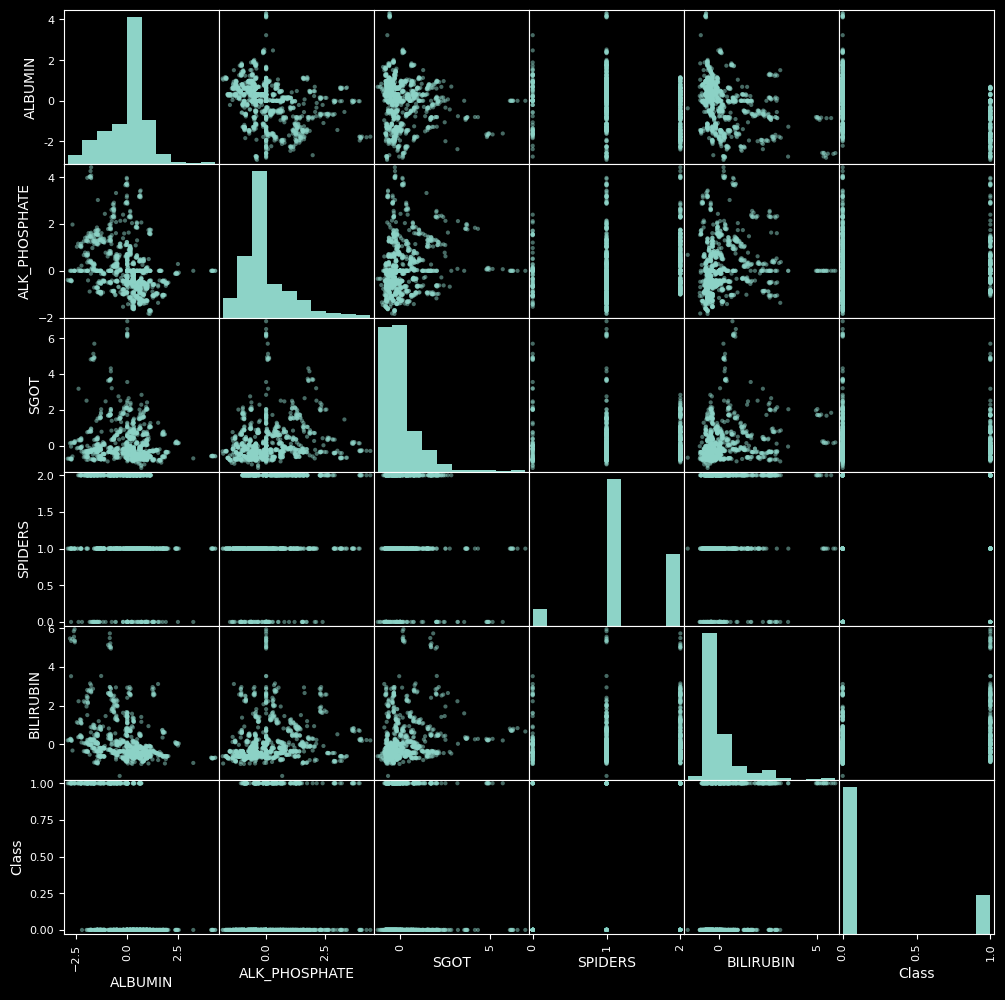

In [15]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["Class"]],
    figsize=(12, 12),
)
plt.show()

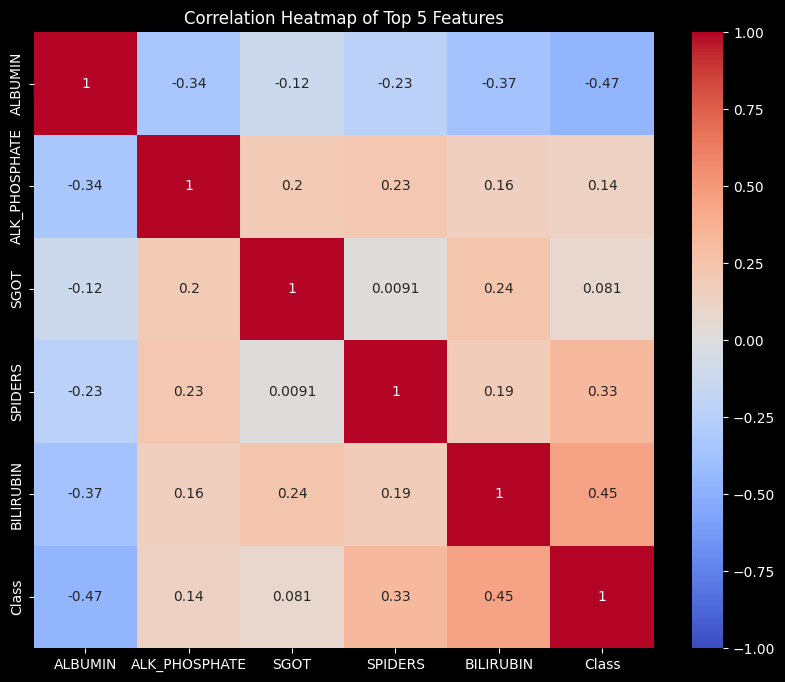

In [16]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["Class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()